In [1]:
from transformers import AutoModel, AutoTokenizer
import torch
import time

In [2]:
from lrp_graph import make_graph
from lrp_prop_fcns import LRPPropFunctions
from add_backward_promise import AddBackwardPromise, compound_promises
from util import create_checkpoint

In [3]:
def checkpoint_hook(module, input, output):
    return create_checkpoint(output)

In [4]:
model_name = "zhihan1996/DNABERT-2-117M"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True)

/Users/kevinlee-talka/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/7bce263b15377fc15361f52cfab88f8b586abda0/bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
for layer_module in model.encoder.layer:
    layer_module.attention.self.register_forward_hook(checkpoint_hook)

In [6]:
dna = "ACGTAGCATCGGATCTATCTATCGACACTTGGTTATCGATCTACGAGCATCTCGTTAGC"
inputs = tokenizer(dna, return_tensors = 'pt')["input_ids"]
hidden_states : torch.Tensor = model(inputs, requires_grad=True)[0] # [1, sequence_length, 768]

In [7]:
from torch.autograd.graph import Node

in_adj_list, out_adj_list, names = make_graph(hidden_states)
input_tracker : dict[Node, list] = { k : [] for k in list(in_adj_list.keys()) }
checkpoints = list(filter(lambda k: type(k).__name__ == "LRPCheckpointBackward", list(in_adj_list.keys())))
num_checkpoints_reached = 0

fcn_map = LRPPropFunctions.generate_prop_fcn_map(names)

In [8]:
start_time = time.time()
visited1 = set()
with torch.no_grad():
    # Create the first relevance layer via max logit.
    m = hidden_states.max(-1)
    relevance = torch.zeros_like(hidden_states)
    b, s, d = hidden_states.shape
    for i, inds in enumerate(m.indices):
        relevance[i,list(range(s)),inds] = torch.ones_like(m.values[0])

    # Setup the first iteration
    input_tracker[hidden_states.grad_fn] = [ relevance ]
    stack = [hidden_states.grad_fn]
    in_adj_list[hidden_states.grad_fn] = []
    nodes_pending = { k : len(v) for k, v in list(in_adj_list.items()) }

    promise_queue : list[Node] = []

    promise_traversal_stack = []
    promise_traversal_mode = False

    promise_fulfillment_mode = False

    while (stack or promise_traversal_stack or promise_queue) and num_checkpoints_reached < len(checkpoints):
        
        curnode = None
        
        # Decide where we should take curnode from
        if promise_queue and any(fcn.metadata["promise"]["complete"] for fcn in promise_queue):
            # Search for the first complete promise in the queue.
            curnode = next(( fcn for fcn in promise_queue if fcn.metadata["promise"]["complete"] ))
            idx = promise_queue.index(curnode)
            promise_queue = promise_queue[:idx] + promise_queue[idx + 1:]
            promise_traversal_mode = False
            promise_fulfillment_mode = True

        elif promise_queue and any(nodes_pending[fcn] == 0 and "pre_promise" in fcn.metadata and
                                   all(parent.complete for parent in fcn.metadata["pre_promise"].parents)
                                   for fcn in promise_queue):
            # Promises that come from the pre_promise flow, they should be ready but they were created
            # in promise traversal mode, so their in-relevances are not yet calculated.
            curnode = next(( fcn for fcn in promise_queue if nodes_pending[fcn] == 0 and 
                            all(parent.complete for parent in fcn.metadata["pre_promise"].parents) ))
            idx = promise_queue.index(curnode)
            promise_queue = promise_queue[:idx] + promise_queue[idx + 1:]

            # We can process these like normal actually
            promise_traversal_mode = False
            promise_fulfillment_mode = False

        elif promise_traversal_stack:
            # Second priority is promise traversal, which overrides the requirement for all inputs to land
            # before traversing a node. However, the promise will not have its rins computed until 
            curnode = promise_traversal_stack[0]
            promise_traversal_stack = promise_traversal_stack[1:]
            promise_traversal_mode = True
            promise_fulfillment_mode = False

        elif stack:
            # Fallback to main stack
            curnode = stack[0]
            stack = stack[1:]
            promise_traversal_mode = False
            promise_fulfillment_mode = False

        curnode_inputs = input_tracker[curnode]

        visited1.add(curnode) # For debugging

        # According to next_functions
        children = out_adj_list[curnode]

        if not promise_fulfillment_mode:

            # Categorize all inputs into either pending promises, complete promises, or tensors
            pending_promise_inputs = []
            complete_promise_inputs = []
            tensor_inputs = []
            for input_ in curnode_inputs:
                if isinstance(input_, torch.Tensor):
                    tensor_inputs.append(input_)
                elif isinstance(input_, AddBackwardPromise) and input_.complete:
                    complete_promise_inputs.append(input_)
                elif isinstance(input_, AddBackwardPromise):
                    pending_promise_inputs.append(input_)
                elif input_ == 0.0:
                    continue
                else:
                    print(input_)
                    raise ValueError(f"Expected relevance input to Node {curnode} to be type AddBackwardPromise or Tensor, but got {type(input_)} instead.")
    
            if not complete_promise_inputs and not pending_promise_inputs and not tensor_inputs:
                continue
    
            # Aggregate all inputs into one Tensor or AddBackwardPromise
            curnode_in_rel = sum(tensor_inputs) + sum([ p.rin for p in complete_promise_inputs ])
            if pending_promise_inputs:
                # In promise traversal mode this will be True
                agg_promises = compound_promises(pending_promise_inputs, promise_traversal_mode, promise_traversal_mode)
                if curnode_in_rel != 0:
                    curnode_in_rel = agg_promises + curnode_in_rel
                else:
                    curnode_in_rel = agg_promises
        else:
            # In promise fulfillment mode, use the completed promise's rin for traversing curnode.
            curnode_in_rel = curnode.metadata["promise"]["rins"][curnode.metadata["promise_idx"]]


        if not promise_traversal_mode and "pre_promise" in curnode.metadata:
            # We have already traversed a promise tree, but have not calculated its bwd,
            # since it was done in promise traversal mode.
            pre_promise : AddBackwardPromise = curnode.metadata["pre_promise"]

            assert pre_promise.ready, f"Pre-promise at {curnode} was assumed to be ready but was not."

            if not pre_promise.complete:
                if isinstance(curnode_in_rel, AddBackwardPromise):
                    # If there is still pending promises at this node, try to complete them via the aggregate promise.
                    # In the case this completes and propagates relevance down, we will have to pick up from the tail nodes
                    # of the aggregate promise.
                    curnode_in_rel.children.append(pre_promise)
                    curnode_in_rel.setarg(pre_promise.arg1 + pre_promise.arg2)
                else:
                    # Manually set the rout and trigger the promise to finish the backward prop.
                    pre_promise.accumulate_rout(curnode_in_rel)
                    pre_promise.trigger_promise_completion()

            tail_nodes = pre_promise.promise["tail_nodes"]
            if curnode in tail_nodes:
                tail_nodes.remove(curnode)
            if tail_nodes:
                # Don't know if the promise is complete yet, so put on the promise queue.
                # If any are done, they will be traversed with priority.
                promise_queue += tail_nodes
                continue
            else:
                # If the pre-promise is a singleton, i.e. the node is the tail of its own pre-promise,
                # just collect the computed rin and re-traverse this node with a tensor rin input like normal.
                curnode_in_rel = pre_promise.rin

        if promise_traversal_mode:
            # We want to save this so later we'll know we've already traversed this node.
            curnode.metadata["pre_promise"] = curnode_in_rel

        # Call the propagation function for the node
        curnode_outputs = fcn_map[type(curnode).__name__](curnode, curnode_in_rel)

        if isinstance(curnode_outputs, AddBackwardPromise) and curnode_outputs.arg is not None and not curnode_outputs.complete:
            # Node is waiting on Promise to be completed, add to promise queue and come back later.
            curnode.metadata["promise"] = curnode_outputs.promise
            curnode.metadata["promise_idx"] = curnode_outputs.idx
            promise_queue.append(curnode)
            continue

        # Children may contain None, like grad_fn.next_functions, to keep integrity of input tracking
        if len(children) == 0 or all(child is None for child in children):
            continue
        elif len(children) == 1:
            curnode_outputs = [ curnode_outputs ]
            
        elif len(children) != len(curnode_outputs):
            raise ValueError(f"Mismatch: {len(children)} children but {len(curnode_outputs)} outputs from {curnode}.")


        # Update child inputs
        for i, child in enumerate(children):
            if child is None:
                # Discard the input (it shouldn't have value anyway), if it's a promise make it a zero-promise
                if isinstance(curnode_outputs[i], AddBackwardPromise):
                    curnode_outputs[i].promise["args"][curnode_outputs[i].idx] = 0.0
                continue
            input_tracker[child].append(curnode_outputs[i])
            nodes_pending[child] -= 1
            assert nodes_pending[child] >= 0, f"Negative pending count for node {child}"
            assert len(input_tracker[child]) <= len(in_adj_list[child]), \
                f"Too many inputs landed for {child}"

        # Collect children who now have all their inputs or that have promise(s) depending on them.
        ready_children = []
        promise_depends_on = []
        for i, child in enumerate(children):
            if child is None:
                continue
            if nodes_pending[child] == 0 and child not in promise_queue:
                ready_children.append(child)
            elif isinstance(curnode_outputs[i], AddBackwardPromise) and not curnode_outputs[i].complete and "pre_promise" not in child.metadata:
                promise_depends_on.append(child)

        promise_traversal_stack = promise_depends_on + promise_traversal_stack
        stack = ready_children + stack
        num_checkpoints_reached = sum([ "checkpoint_relevance" in checkpoint.metadata for checkpoint in checkpoints])

end_time = time.time()
print(f"took {end_time - start_time} seconds")
# Sorted in desc because they are indexed in the order that we save them in (going backwards).
checkpoints = sorted(checkpoints, key=lambda c: c.metadata["checkpoint_ind"], reverse=True)
checkpoint_vals = [ checkpoint.metadata["checkpoint_relevance" ] for checkpoint in checkpoints ]

doing manual rout setting and promise completion
doing manual rout setting and promise completion
doing manual rout setting and promise completion
doing manual rout setting and promise completion
doing manual rout setting and promise completion
doing manual rout setting and promise completion
doing manual rout setting and promise completion
doing manual rout setting and promise completion
doing manual rout setting and promise completion
doing manual rout setting and promise completion
doing manual rout setting and promise completion
doing manual rout setting and promise completion
doing manual rout setting and promise completion
doing manual rout setting and promise completion
doing manual rout setting and promise completion
doing manual rout setting and promise completion
doing manual rout setting and promise completion
doing manual rout setting and promise completion
doing manual rout setting and promise completion
doing manual rout setting and promise completion
doing manual rout se

In [9]:
visited = sorted(list(visited1), key=lambda x: x._sequence_nr())
visited_map = { str(node) : node for node in visited }
promises = AddBackwardPromise.all_promises

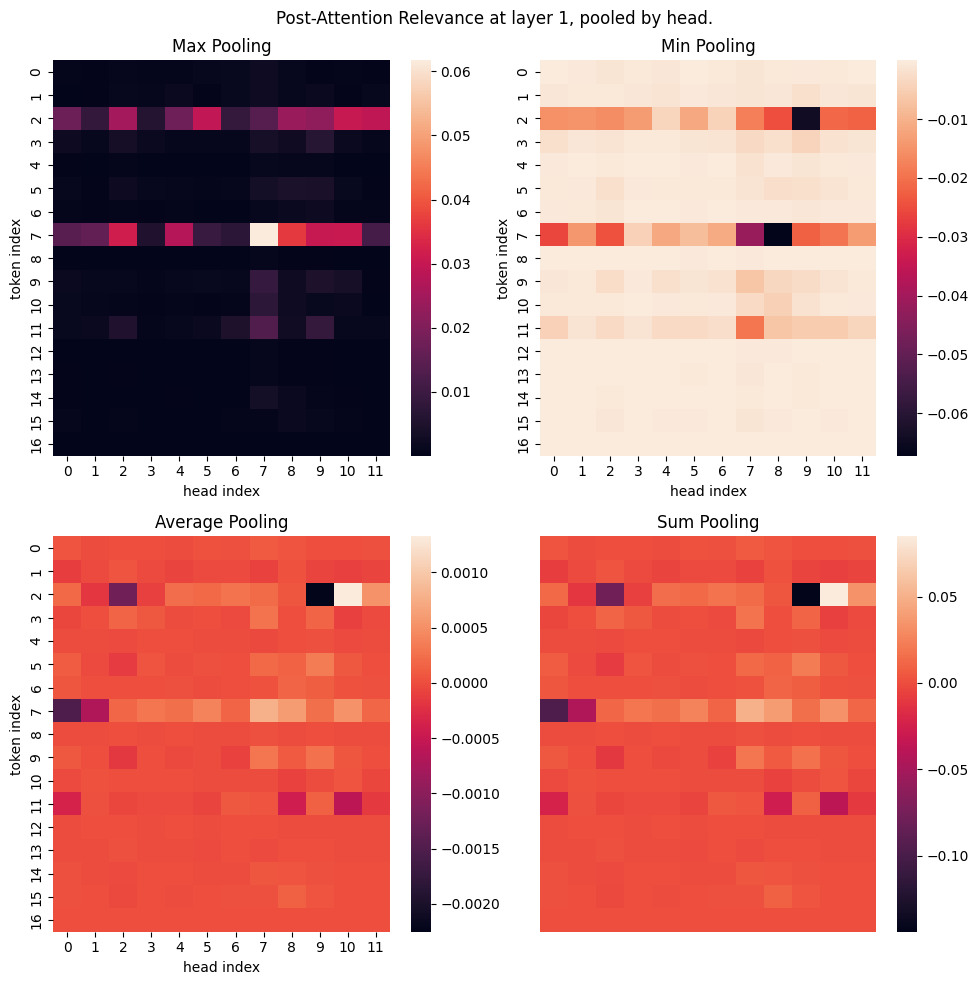

In [12]:
# Visualizing relevance of attention mechanism
import seaborn as sns
import matplotlib.pyplot as plt
from util import MinPool1d

# Set this to which layer you want to see
layer_ind = 1

# Use pooling with kernel size and stride set to d_head = d_model / num_heads = 64 (for DNABERT2)
max_pool = torch.nn.MaxPool1d(kernel_size=64, stride=64)
min_pool = lambda x: -max_pool(-x)
avg_pool = torch.nn.AvgPool1d(kernel_size=64, stride=64)
sum_pool = torch.nn.LPPool1d(kernel_size=64, stride=64, norm_type=1)

pools = {
    "Max Pooling": max_pool,
    "Min Pooling": min_pool,
    "Average Pooling": avg_pool,
    "Sum Pooling": sum_pool,
}

fig, axs = plt.subplots((len(pools) + 1) // 2, 2, figsize=(10,10))
fig.subplots_adjust(top=1.0)

for i, (pool_name, pool_layer) in enumerate(list(pools.items())):
    # Make a heatmap for each type of pooling
    checkpoint_output = pool_layer(torch.unsqueeze(checkpoint_vals[layer_ind], 0))
    sns.heatmap(checkpoint_output.view((17, 12)), ax=axs[i // 2, i % 2])
    axs[i // 2, i % 2].set_title(pool_name)
    axs[i // 2, i % 2].set_xlabel("head index")
    axs[i // 2, i % 2].set_ylabel("token index")

# Remove overflow subplot
if i < ((len(pools) + 1) // 2) * 2:
    axs[i // 2, 1].set_axis_off()
fig.suptitle(f"Post-Attention Relevance at layer {layer_ind}, pooled by head.")
fig.tight_layout()

plt.show()

9 17
['arf_layout', 'bipartite_layout', 'circular_layout', 'fruchterman_reingold_layout', 'kamada_kawai_layout', 'layout', 'multipartite_layout', 'planar_layout', 'random_layout', 'rescale_layout', 'shell_layout', 'spectral_layout', 'spiral_layout', 'spring_layout']


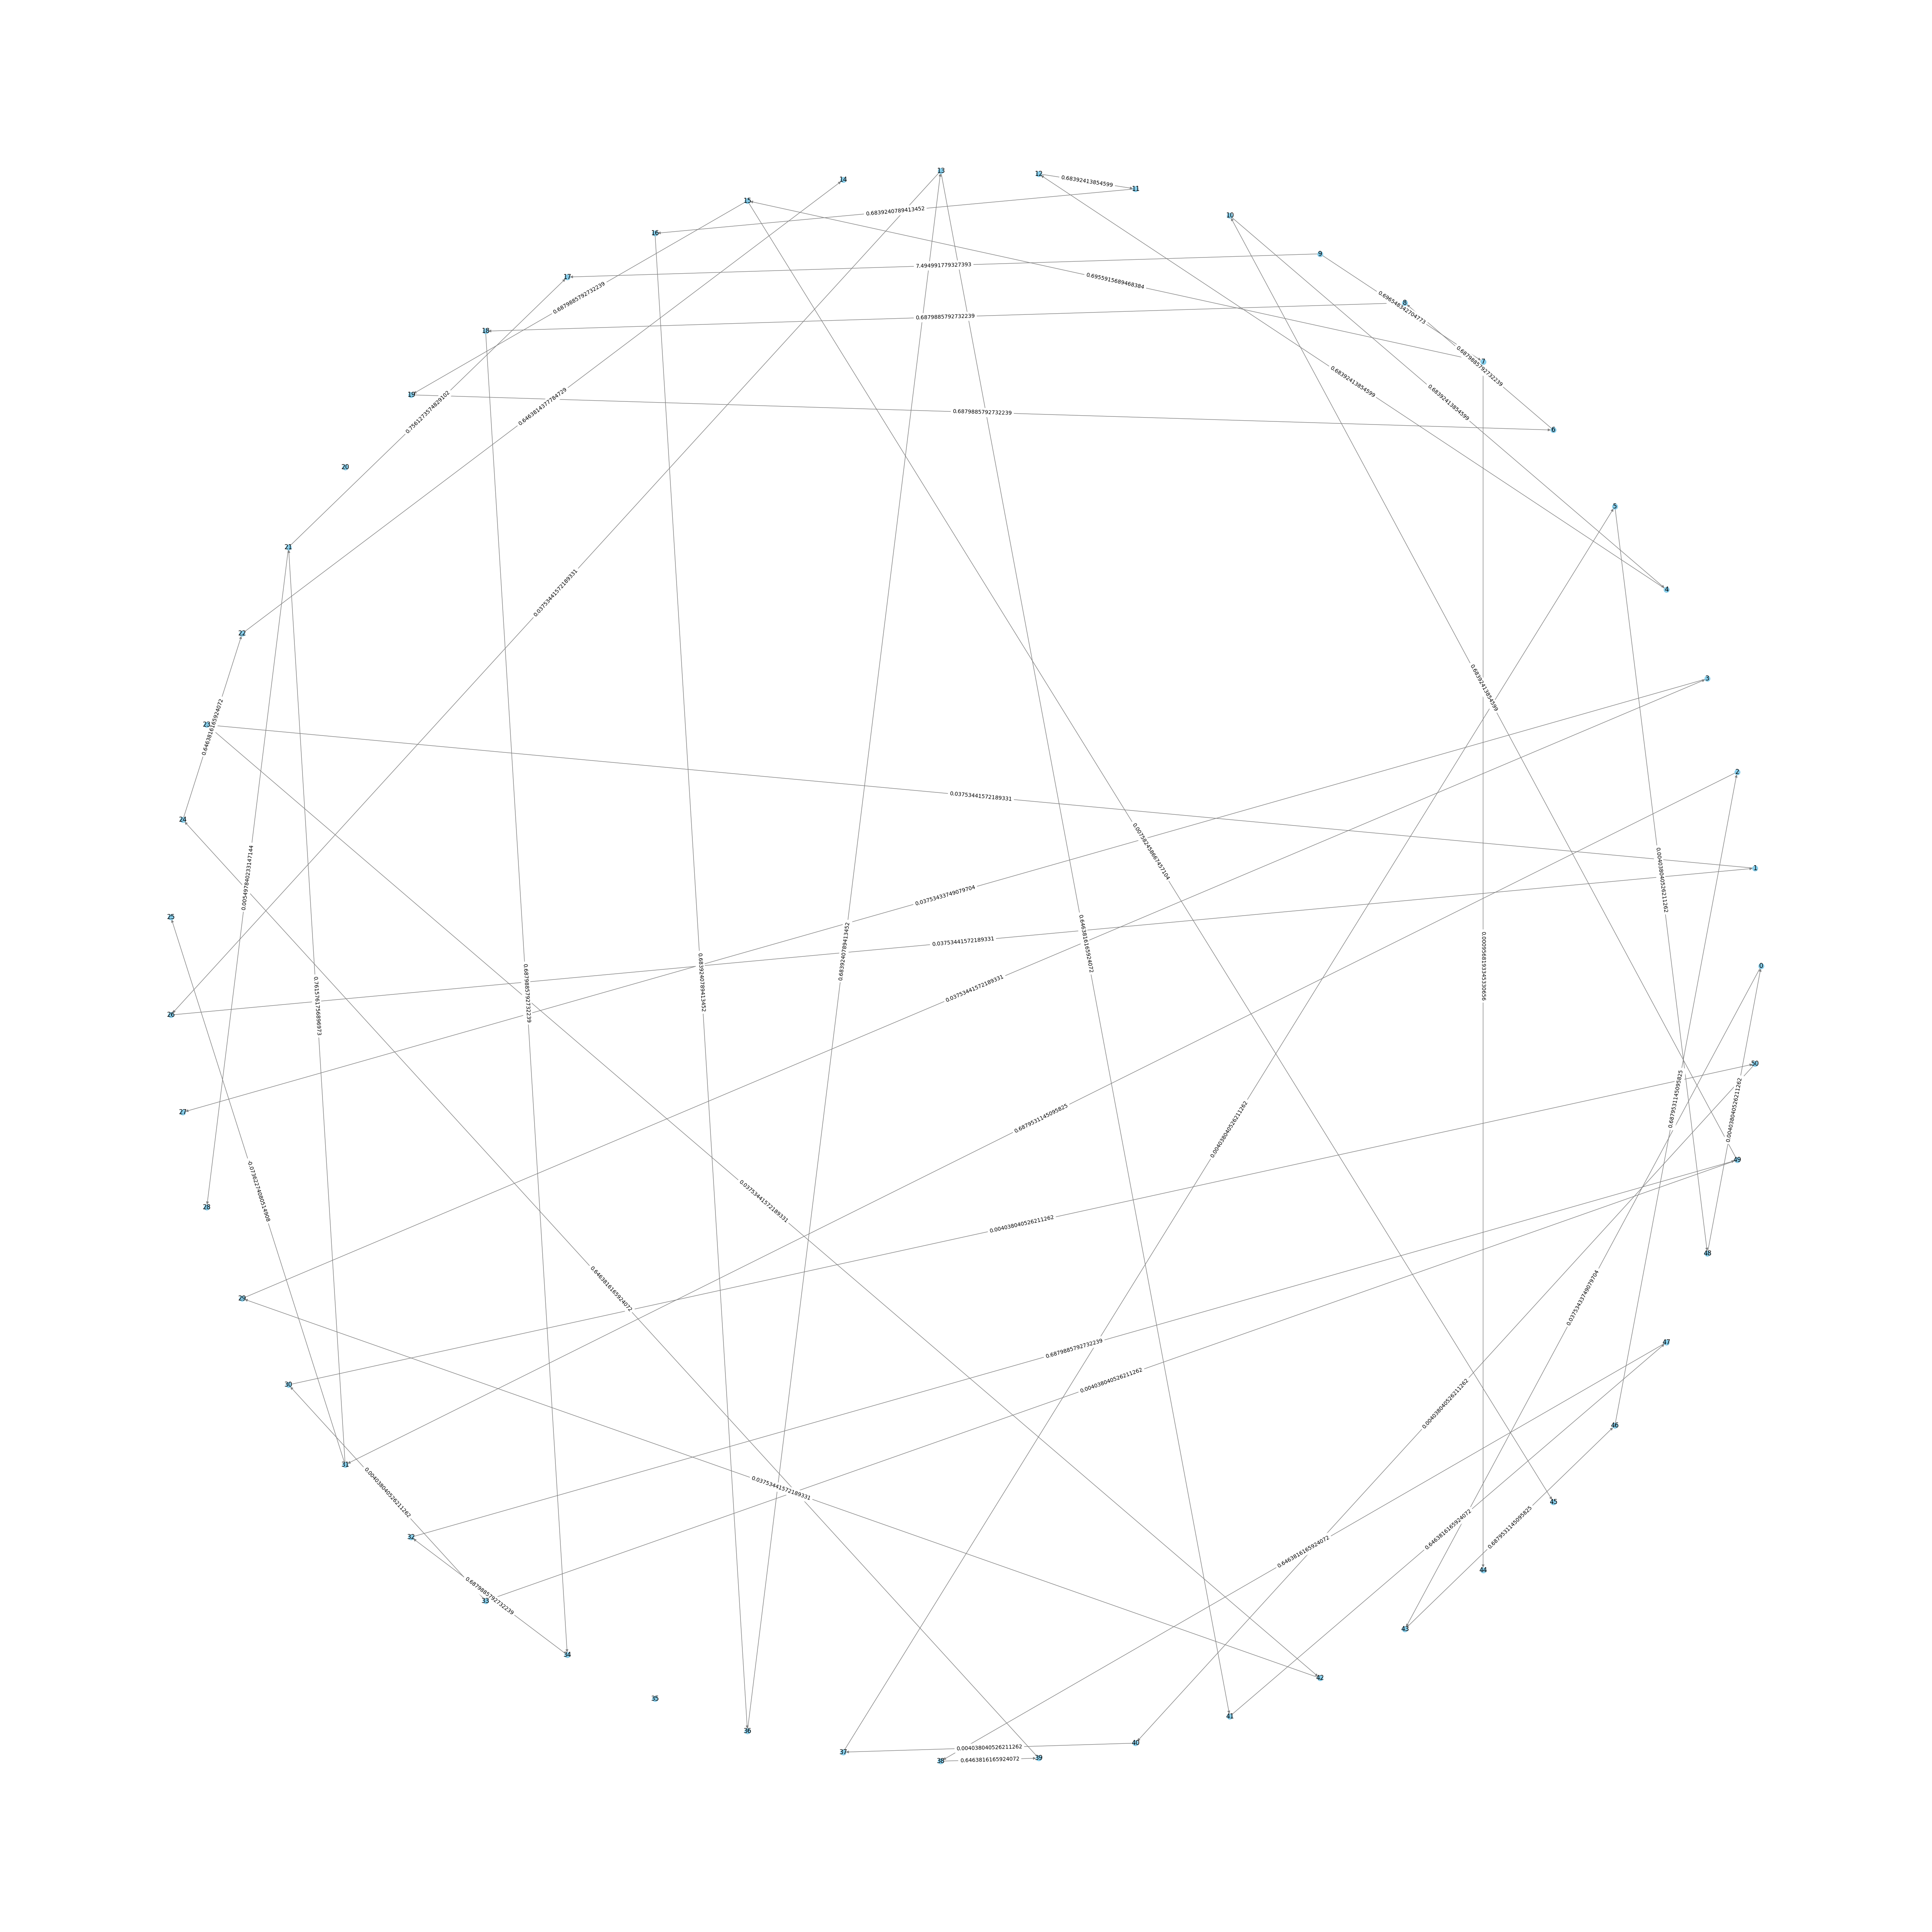

{(0, 43): 0.03753433749079704, (1, 23): 0.03753441572189331, (2, 31): 0.6879531145095825, (3, 27): 0.03753433749079704, (4, 12): 0.68392413854599, (5, 48): 0.004038040526211262, (6, 8): 0.6879885792732239, (7, 44): 0.0009568193345330656, (7, 15): 0.6955915689468384, (8, 18): 0.6879885792732239, (9, 17): 7.494991779327393, (9, 7): 0.696548342704773, (10, 4): 0.68392413854599, (11, 16): 0.6839240789413452, (12, 11): 0.68392413854599, (13, 26): 0.03753441572189331, (13, 41): 0.6463816165924072, (15, 19): 0.6879885792732239, (15, 45): 0.007582458667457104, (16, 36): 0.6839240789413452, (18, 34): 0.6879885792732239, (19, 6): 0.6879885792732239, (21, 17): 0.7561273574829102, (21, 28): 0.005497840233147144, (22, 14): 0.6463814377784729, (23, 42): 0.03753441572189331, (24, 22): 0.6463816165924072, (26, 1): 0.03753441572189331, (29, 3): 0.03753441572189331, (30, 50): 0.004038040526211262, (31, 25): -0.07362274080514908, (31, 21): 0.7615761756896973, (32, 49): 0.6879885792732239, (33, 30): 0.004

In [17]:
# For debugging relevance paths

# import networkx as nx
# import matplotlib.pyplot as plt

# node_to_ind = { node : i for (i, node) in enumerate(nodes) }
# def create_graph(nodes, in_adj_list, weights, alpha = 0.5):    
#     G = nx.DiGraph()
#     G.add_nodes_from(range(len(nodes)))

#     print(node_to_ind[start], node_to_ind[end]) # Global vars, set somewhere

#     for node, in_nodes in list(in_adj_list.items()):
#         if node not in nodes:
#             continue
#         for in_node, in_weight in zip(in_nodes, input_tracker[node]):
#             if in_node not in nodes:
#                 continue
#             if isinstance(in_weight, AddBackwardPromise):
#                 if in_weight.complete:
#                     in_weight = in_weight.rin.sum()
#                 else:
#                     continue
#             elif isinstance(in_weight, torch.Tensor):
#                 in_weight = in_weight.sum()
#             G.add_edge(node_to_ind[in_node], node_to_ind[node], weight=float(in_weight))
#     return G

# def display_graph(G):
#     pos = nx.circular_layout(G)  
#     weight_labels = nx.get_edge_attributes(G, 'weight')
#     plt.figure(figsize=(50,50))
#     nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=100)
#     nx.draw_networkx_edge_labels(G, pos, edge_labels=weight_labels)  
#     plt.show()

# G = create_graph(nodes, in_adj_list, input_tracker)

# print([ x for x in dir(nx) if x.endswith("layout") ])
# display_graph(G)
# print(nx.get_edge_attributes(G, 'weight'))


In [23]:
# Check that promises maintain conservation property
complete = list(filter(lambda p: p.complete, promises))
for p in complete:
    rout = p.promise["rout"].sum()
    rin = p.promise["rins"][0].sum() + p.promise["rins"][1].sum()
    if (rout - rin) / rout > 0.00001:
        print(rout, rin)
        

In [20]:
# Checking conservation holds across the entire propagation
# The frontier includes:
# a) true leaf nodes (no children)
# b) nodes which received inputs but were never traversed due to computation ending early

frontier = [ node 
            for node, out_nodes in list(out_adj_list.items())
            if len(out_nodes) == 0
           ]

frontier += [ node for node in stack if input_tracker[node] ]

frontier = list(set(frontier))

In [22]:
# Tally the total relevance at the frontier
total_frontier_in = 0.0
for node in frontier:
    total_in = 0.0
    for input_ in input_tracker[node]:
        if isinstance(input_, AddBackwardPromise):
            if input_.complete:
                total_in += input_.rin.sum()
            else:
                continue
        elif isinstance(input_, torch.Tensor):
            total_in += input_.sum()
    total_frontier_in += total_in
print(total_frontier_in)

tensor(17.0376)
